In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.model_selection as model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


In [2]:
#read data and change to pandas dataframe format
data = pd.read_json('ultimate_data_challenge.json')
df = pd.DataFrame(data)
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [3]:
#check size of data
df.shape

(50000, 12)

In [4]:
#examine data types
df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [5]:
#since this is a classification problem, all features need to be in numeric type
#first check missing values
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

In [6]:
#check statistics of this data
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [7]:
#convert to datetime type for signup_date and last_trip_date
df['signup_date']=pd.to_datetime(df['signup_date'])
df['last_trip_date']=pd.to_datetime(df['last_trip_date'])
(df['last_trip_date'] - df['signup_date']).dt.days

0        143
1         96
2          1
3        170
4         47
        ... 
49995    131
49996      1
49997    111
49998      1
49999     92
Length: 50000, dtype: int64

In [8]:
#take the difference and see if it is great than 180
df['active_after_6month'] = (df['last_trip_date'] - df['signup_date']).dt.days > 150 
df['active_after_6month'] =  (df['active_after_6month']==1). astype(int)

In [9]:
#fill missing dat with mean because simply dropping these rows will lose about 1/12 of whole data
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(),inplace=True)
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(),inplace=True)

In [10]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,active_after_6month
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158,0.243960
std,3.792684,0.564977,0.222336,19.958811,37.081503,5.707357,0.445753,0.429473
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,4.500000,1.000000,0.000000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,4.700000,1.000000,0.000000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,0.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,1.000000


In [11]:
#now no more missing values except phone column
df.isnull().sum()

city                        0
trips_in_first_30_days      0
signup_date                 0
avg_rating_of_driver        0
avg_surge                   0
last_trip_date              0
phone                     396
surge_pct                   0
ultimate_black_user         0
weekday_pct                 0
avg_dist                    0
avg_rating_by_driver        0
active_after_6month         0
dtype: int64

In [12]:
#merge features avg_rating_of_driver with avg_rating_by_driver by using mean of two
df['avg_rating']=(df['avg_rating_of_driver'] + df['avg_rating_by_driver'])/2

In [13]:
#drop city, phone and date columns since there are not useful features
df.drop(columns=['signup_date','last_trip_date','phone','city','avg_rating_of_driver','avg_rating_by_driver'],inplace=True)
df.head(20)

,trips_in_first_30_days,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,active_after_6month,avg_rating
0,4,1.10,15.4,True,46.2,3.67,0,4.85000
1,0,1.00,0.0,False,50.0,8.26,0,5.00000
2,3,1.00,0.0,False,100.0,0.77,0,4.65000
3,9,1.14,20.0,True,80.0,2.36,1,4.75000
4,14,1.19,11.8,False,82.4,3.13,0,4.65000
5,2,1.00,0.0,True,100.0,10.56,0,4.25000
6,1,1.00,0.0,False,100.0,3.95,0,4.30078
7,2,1.00,0.0,False,100.0,2.04,0,5.00000
8,2,1.00,0.0,False,100.0,4.36,0,4.75000
9,1,1.00,0.0,False,0.0,2.37,0,4.80078


In [14]:
#ultimate_black_user is a boolean type, need to change to int
df['ultimate_black_user'] = (df['ultimate_black_user']==1). astype(int)

In [15]:
#now check dataframe
df.head(), df.dtypes

(   trips_in_first_30_days  avg_surge  surge_pct  ultimate_black_user  \
 0                       4       1.10       15.4                    1   
 1                       0       1.00        0.0                    0   
 2                       3       1.00        0.0                    0   
 3                       9       1.14       20.0                    1   
 4                      14       1.19       11.8                    0   
 
    weekday_pct  avg_dist  active_after_6month  avg_rating  
 0         46.2      3.67                    0        4.85  
 1         50.0      8.26                    0        5.00  
 2        100.0      0.77                    0        4.65  
 3         80.0      2.36                    1        4.75  
 4         82.4      3.13                    0        4.65  ,
 trips_in_first_30_days      int64
 avg_surge                 float64
 surge_pct                 float64
 ultimate_black_user         int32
 weekday_pct               float64
 avg_dist         

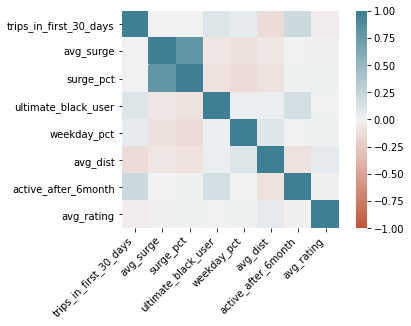

In [16]:
#check corrleation between these features using heatmap
corr = df.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

The above Heapmap shows strong positive correlation between ultimate_black_user and trips_in_first 30days, and negative correlation with ave_rating_of_drive, avg_surge and surge_pct

In [17]:
corr

,trips_in_first_30_days,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,active_after_6month,avg_rating
trips_in_first_30_days,1.000000,-0.001841,0.005720,0.112210,0.050388,-0.136329,0.204841,-0.031385
avg_surge,-0.001841,1.000000,0.793582,-0.078791,-0.110071,-0.081491,0.006267,-0.010013
surge_pct,0.005720,0.793582,1.000000,-0.106861,-0.144918,-0.104414,0.017045,0.009332
ultimate_black_user,0.112210,-0.078791,-0.106861,1.000000,0.035998,0.032310,0.159157,0.004077
weekday_pct,0.050388,-0.110071,-0.144918,0.035998,1.000000,0.101652,0.005518,0.021460
avg_dist,-0.136329,-0.081491,-0.104414,0.032310,0.101652,1.000000,-0.091802,0.068498
active_after_6month,0.204841,0.006267,0.017045,0.159157,0.005518,-0.091802,1.000000,-0.019446
avg_rating,-0.031385,-0.010013,0.009332,0.004077,0.021460,0.068498,-0.019446,1.000000


avg_surge are the same as surge_pct. Weekday_pct is also not significant. Drop these features

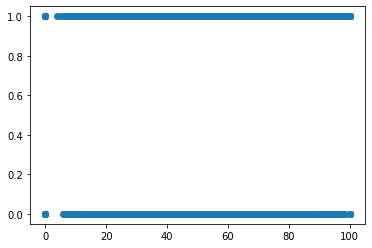

In [18]:
#intuitively, weekday_pct should not affect retetion rate, let's check their correlation
plt.scatter(df.weekday_pct, df.active_after_6month)

In [19]:
df.drop(columns=['avg_surge','weekday_pct'],inplace=True)

array([[<AxesSubplot:title={'center':'trips_in_first_30_days'}>,
        <AxesSubplot:title={'center':'surge_pct'}>],
       [<AxesSubplot:title={'center':'ultimate_black_user'}>,
        <AxesSubplot:title={'center':'avg_dist'}>],
       [<AxesSubplot:title={'center':'active_after_6month'}>,
        <AxesSubplot:title={'center':'avg_rating'}>]], dtype=object)

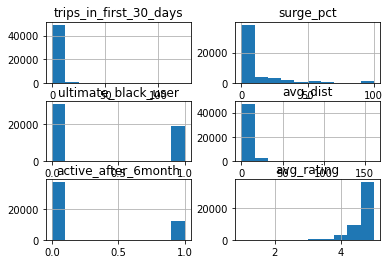

In [20]:
#check distribution of each features
df.hist()

I do not see any obvious outliers

In [21]:
#it is a good idea to keep all these features because more information will not hurt the performance
#train_test_split
y= df['active_after_6month']
X= df.drop('active_after_6month', 1)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.75,test_size=0.25, random_state=101)

In [35]:
X_train.shape

(37500, 5)

In [22]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [23]:
#train model and fit
logreg = LogisticRegression()

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [24]:
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.98      0.86      9438
           1       0.61      0.08      0.14      3062

    accuracy                           0.76     12500
   macro avg       0.69      0.53      0.50     12500
weighted avg       0.73      0.76      0.69     12500

0.76224


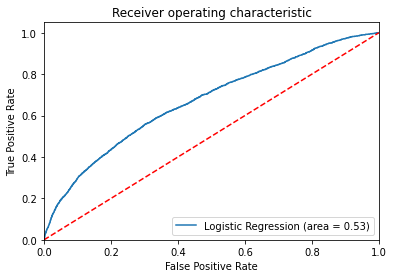

In [25]:
#check ROC curve
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [26]:
#check cross-validation for accuracy scores
scores = cross_val_score(logreg, X_train, y_train, cv=10)
print('Cross-Validation Accuracy Scores', scores)

Cross-Validation Accuracy Scores [0.7632     0.76293333 0.76586667 0.76613333 0.76506667 0.76426667
 0.7552     0.76426667 0.76293333 0.7656    ]


Look like there is some rooms for improvement. 

In [27]:
#Try random forest!
rfmodel = RandomForestClassifier(n_estimators=20, random_state=0)
rfmodel.fit(X_train, y_train)
y_pred = rfmodel.predict(X_test)

In [28]:
print(y_pred)
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

[0 0 0 ... 0 1 0]
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      9438
           1       0.44      0.37      0.41      3062

    accuracy                           0.73     12500
   macro avg       0.63      0.61      0.62     12500
weighted avg       0.72      0.73      0.72     12500

0.73176


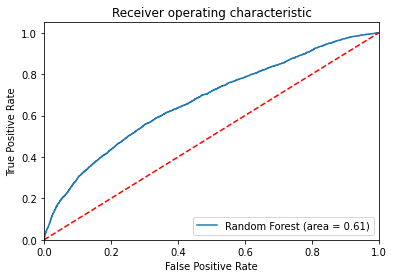

In [29]:
#check ROC curve
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [30]:
#what about support vector machine
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86      9438
           1       0.00      0.00      0.00      3062

    accuracy                           0.76     12500
   macro avg       0.38      0.50      0.43     12500
weighted avg       0.57      0.76      0.65     12500



C:\Users\zcj10\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zcj10\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\zcj10\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


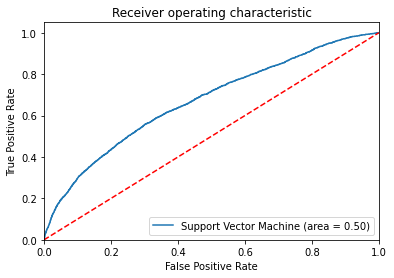

In [32]:
#check ROC curve
logit_roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Support Vector Machine (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [33]:
#use GridSearch to tune hyperparameter, too slow to run
'''
param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}
grid = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=2)
grid.fit(X_train,y_train)
print(grid.best_estimator_)
'''

"\nparam_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}\ngrid = GridSearchCV(svm.SVC(),param_grid,refit=True,verbose=2)\ngrid.fit(X_train,y_train)\nprint(grid.best_estimator_)\n"

In [36]:
#Try neural network 
model = Sequential()
model.add(Dense(12, input_dim=5, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train, y_train, epochs=150, batch_size=10)
# evaluate the keras model
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))

Epoch 1/150
3750/3750 [==============================] - 3s 898us/step - loss: 0.5134 - accuracy: 0.7605
Epoch 2/150
3750/3750 [==============================] - 3s 903us/step - loss: 0.4917 - accuracy: 0.7711
Epoch 3/150
3750/3750 [==============================] - 3s 925us/step - loss: 0.4878 - accuracy: 0.7740
Epoch 4/150
3750/3750 [==============================] - 3s 868us/step - loss: 0.4851 - accuracy: 0.7762
Epoch 5/150
3750/3750 [==============================] - 3s 904us/step - loss: 0.4841 - accuracy: 0.7768
Epoch 6/150
3750/3750 [==============================] - 3s 919us/step - loss: 0.4833 - accuracy: 0.7775
Epoch 7/150
3750/3750 [==============================] - 3s 877us/step - loss: 0.4822 - accuracy: 0.7792
Epoch 8/150
3750/3750 [==============================] - 3s 899us/step - loss: 0.4817 - accuracy: 0.7795
Epoch 9/150
3750/3750 [==============================] - 3s 906us/step - loss: 0.4813 - accuracy: 0.7791
Epoch 10/150
3750/3750 [==============================]

3750/3750 [==============================] - 4s 962us/step - loss: 0.4732 - accuracy: 0.7838
Epoch 79/150
3750/3750 [==============================] - 3s 897us/step - loss: 0.4733 - accuracy: 0.7838
Epoch 80/150
3750/3750 [==============================] - 4s 940us/step - loss: 0.4733 - accuracy: 0.7829
Epoch 81/150
3750/3750 [==============================] - 3s 909us/step - loss: 0.4731 - accuracy: 0.7844
Epoch 82/150
3750/3750 [==============================] - 3s 904us/step - loss: 0.4732 - accuracy: 0.7838
Epoch 83/150
3750/3750 [==============================] - 4s 938us/step - loss: 0.4735 - accuracy: 0.7838
Epoch 84/150
3750/3750 [==============================] - 5s 1ms/step - loss: 0.4729 - accuracy: 0.7836
Epoch 85/150
3750/3750 [==============================] - 6s 2ms/step - loss: 0.4735 - accuracy: 0.7836
Epoch 86/150
3750/3750 [==============================] - 5s 1ms/step - loss: 0.4732 - accuracy: 0.7833
Epoch 87/150
3750/3750 [==============================] - 5s 1ms/

This improves accuracy from 76 to 78.45%! The retetion rate has more to do with number of trips made in first 30 days and whether they sign up Ultimate Black in those days. Therefore, it is important for the company to provide good servive for the first 30 days after they sign up. 